# Soft Actor-Critic with recurrent policy function
**Stabilization of a particle moving on a straight line**

### Import libraries

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from IPython.display import clear_output
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec

import pickle

# import local libraries
from environments.linear import Linear_SDI
from src.SACRNN.main import SACAgent
from src.OptimalControl.LQR import LQRSolver

### Initialization

In [2]:
def create_agent(key):
    # parameters
    memory_size = 1000
    batch_size = 128
    initial_random_steps = 200#1000

    control_limit = 4.
    obs_size = 2
    ctrl_size = 1

    env = Linear_SDI(end_time=10)

    agent = SACAgent(
        env, memory_size, key, 
        initial_random_steps=initial_random_steps, 
        obs_size=obs_size, 
        ctrl_size=ctrl_size,
        control_limit=control_limit,
        epochs_per_step=10,
        lr=1e-2,
        history_size=8,
        memory_decay=5e-3
    )
    return agent

## Training

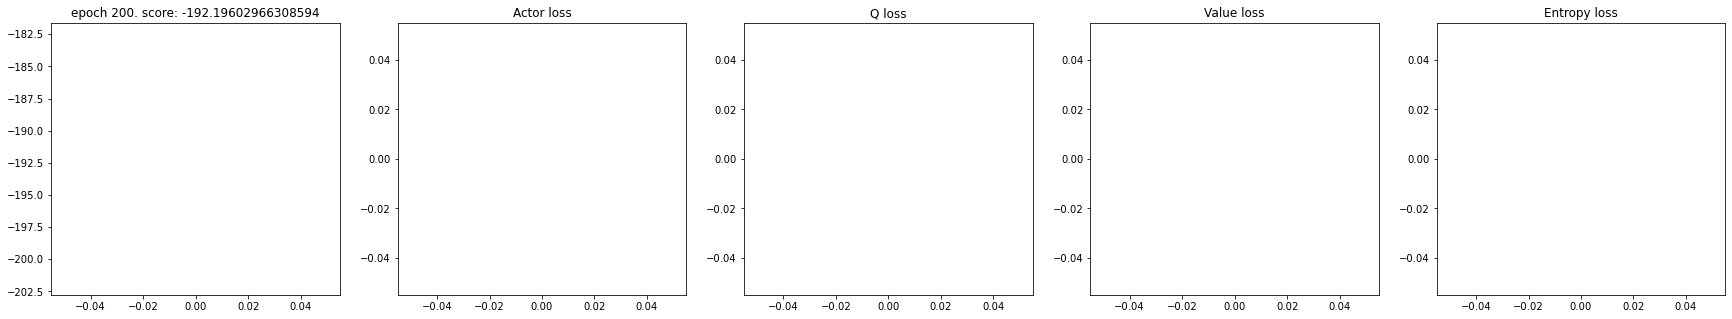

In [3]:
memory = {'recording':[], 'dt':[], 'seed':[]}
for seed in [0]:
    np.random.seed(seed)
    key = jrandom.PRNGKey(seed)

    agent = create_agent(key)

    agent.train(2000, key, plotting_interval=100, record=True)

    memory['recording'].append(agent.recording)
    memory['dt'].append(agent.env.dt)
    memory['seed'].append(seed)


## Results

In [4]:
def run(
    key,
    env,
    controller,
    T,
    x0 = None,
    n_obs = 2
):
    t_space = np.arange(0, T, env.dt)

    Y = np.zeros((len(t_space), n_obs))
    S = np.zeros((len(t_space), n_obs))

    y = env.reset(x0)
    for idx, t in enumerate(np.arange(0, T, agent.env.dt)):
        u = controller(y)
        y, rew, done, _ = env.step(u)
        Y[idx] = y
        S[idx] = env.state
    
    return S, Y

def run_recurrent(
    key,
    env,
    controller,
    T,
    x0 = None,
    n_obs = 2
):
    t_space = np.arange(0, T, env.dt)

    Y = np.zeros((len(t_space), n_obs))
    S = np.zeros((len(t_space), n_obs))

    y_prev = env.reset(x0)
    u_prev = jnp.array([0])
    hid = jnp.zeros((2,))
    for idx, t in enumerate(np.arange(0, T, agent.env.dt)):
        u, _, hid = controller(y_prev, u_prev, hid, key)
        y, rew, done, _ = env.step(u)
        Y[idx] = y
        S[idx] = env.state
        
        # param update
        key, _ = jrandom.split(key)
        u_prev = u
        y_prev = y
    
    return S, Y


### Phase plane

(-4.0, 4.0)

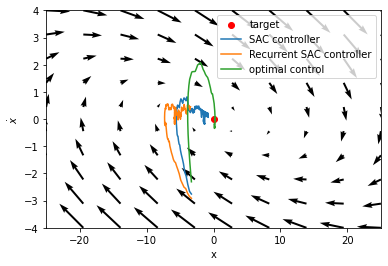

In [13]:
N = 10

x_space = np.linspace(-25, 25, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    control = agent.actor.model.predict(state)
    dx, dv = agent.env.predict_deriv(state, control)
    qx[i,j] = dx
    qv[i,j] = dv

fig, ax = plt.subplots()
ax.scatter(0, 0, c='r', label='target')

env = agent.env
controller = agent.actor.model.predict
S, Y = run(key, env, controller, 20, x0=jnp.array([-3, -3]))
ax.plot(S[:,0], S[:,1], label='SAC controller')

env = agent.env
controller = agent.rec_actor.step
S, Y = run_recurrent(key, env, controller, 20, x0=jnp.array([-3, -3]))
ax.plot(S[:,0], S[:,1], label='Recurrent SAC controller')

env = agent.env
LQR = LQRSolver(env.A, env.B, env.G, env.R)
S, Y = run(key, env, LQR, 5, x0=jnp.array([-3, -3]))
ax.plot(S[:,0], S[:,1], label='optimal control')

ax.quiver(xv, vv, qx, qv)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel(r'$\dot{x}$')
ax.set_xlim([-25, 25])
ax.set_ylim([-4, 4])

In [9]:
key = jrandom.PRNGKey(0)
hid = jnp.zeros(2)
agent.rec_actor.step(jnp.array([-10, -1]), jnp.array([0]), hid, key)


(Array([-0.6140222], dtype=float32),
 Array([1.2229614], dtype=float32),
 Array([-0.00102955,  0.99341565], dtype=float32))

### Network surface plots

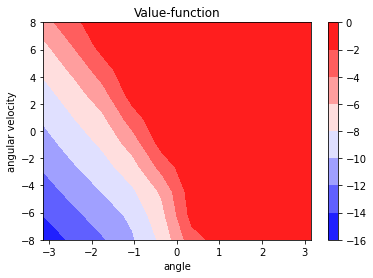

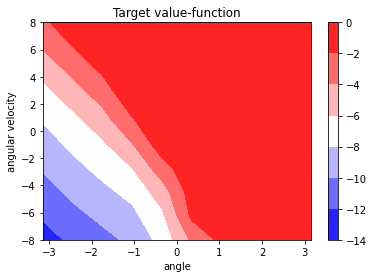

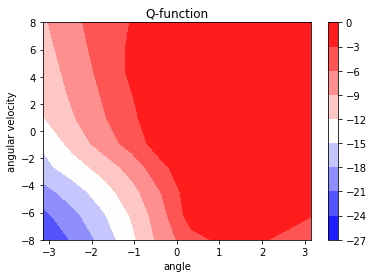

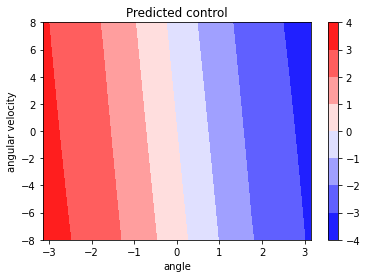

In [6]:
# Value and policy functions

N = 10
x_space = np.linspace(-np.pi, np.pi, N)
v_space = np.linspace(-8, 8, N)
xv, vv = np.meshgrid(x_space, v_space)
Q = np.zeros((N, N))
V = np.zeros((N, N))
V_target = np.zeros((N, N))
U = np.zeros((N, N))

for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    #state = jnp.array([np.cos(x), np.sin(x), v])   # Cartesian coordinate system
    state = jnp.array([x, v])                       # Polar coordinate system
    control = jnp.array([0])
    V[i, j] = agent.VF(state)
    V_target[i, j] = agent.VF_target(state)
    Q[i, j] = agent.q_min(state, control)
    U[i, j] = agent.actor.model.predict(state)

fig, ax = plt.subplots()
plt.contourf(xv, vv, V, cmap=cm.bwr)
plt.colorbar()
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Value-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, V_target, cmap=cm.bwr)
plt.colorbar()
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Target value-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, Q, cmap=cm.bwr)
plt.colorbar()
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Q-function')
plt.show()

fig, ax = plt.subplots()
plt.contourf(xv, vv, U, cmap=cm.bwr)
plt.colorbar()
plt.xlabel('angle')
plt.ylabel('angular velocity')
plt.title('Predicted control')
plt.show()
